In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import image_loader
import torch
from torchvision import transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt

from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

from tqdm import tqdm
import numpy as np

import copy

csv_file = '../data/movie_data2.csv'
img_dir = '../data/MoviePosters'

In [3]:
# Parameters?

useTransforms = False
numEpochs = 20
genres = ['Horror']

In [4]:
transformVar = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(p = 0.25),
    transforms.RandomVerticalFlip(p = 0.25),
    transforms.RandomRotation(60)
])

if not useTransforms:
    transformVar = None

In [5]:
pod = image_loader.PosterDataset(csv_file, img_dir, transform = transformVar, genres = genres)

In [6]:
len(pod)

3581

In [7]:
# just a test to see if transformations work

# save_image(pod.__getitem__(0)[0] / 255, 'test.png')

In [8]:
from torch.utils.data import DataLoader

trainSize = int(len(pod) * 0.9)
testSize = len(pod) - trainSize

trainData, testData = torch.utils.data.random_split(pod, [trainSize, testSize])
def batch_function(raw_output):
    xs, ys = zip(*raw_output)
    batchxs = torch.nn.utils.rnn.pad_sequence(xs, batch_first=True)
    batchys = torch.Tensor(ys)
    return batchxs, batchys

BATCH_SIZE = 5
trainDataLoader = DataLoader(trainData, batch_size = BATCH_SIZE, shuffle=True, collate_fn=batch_function)
testDataLoader = DataLoader(testData, batch_size = 1, shuffle=True)

In [9]:
xs, ys = next(iter(trainDataLoader))
xs[0].shape

C:\Users\terre\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 256, 256])

In [10]:
len(trainData)

3222

In [11]:
# download VGG19 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.vgg19_bn(pretrained=True, progress=True).features.to(device).eval()

C:\Users\terre\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\terre\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
print(device)

cuda


In [13]:
# Initialize the model
# num_features = model.features[-1].out_channels  # Get the number of output channels of the last convolutional layer
# model.features.add_module('7', nn.Conv2d(num_features, 1, 1))  # Add a 1x1 convolutional layer to change the output size to 1
model = model.to(device)

# Define the loss function and optimizer
# criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [14]:
class MoviePredictor(torch.nn.Module):
    def __init__(self, vggmodel, linear_params):
        super().__init__()
        self.vggmodel = vggmodel
        self.predictor_1 = torch.nn.Linear(512 * 8 * 8, linear_params)
        self.out = torch.nn.Linear(linear_params, 1)
    def forward(self, input: torch.Tensor):
        vgg_out = self.vggmodel(input).reshape(input.shape[0], 512 * 8 * 8)
        output = self.out(self.predictor_1(vgg_out))
        return output

In [15]:
predictor_model = MoviePredictor(model, linear_params= 512).to(device)

In [16]:
predictor_model(pod[1][0][None,:,:,:].to(device))

tensor([[0.9328]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [17]:
trainLossPlt = []
testLossPlt = []

In [18]:
# Train the model
def train_model(in_model, criterion, optimizer, num_epochs):
    # uses global training data
    print(f"Training for {num_epochs} epoch(s).")
    
    for epoch in range(num_epochs):
        in_model.train()
        running_loss = 0.0
        pbar = tqdm(trainDataLoader)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = in_model(images)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            if np.isnan(loss.item()).any():
                print("NaN encountered in calculating loss, aborting")
                print(f"Predictions: {outputs}")
                print(f"Labels: {labels}")
                return

            running_loss += loss.item()
            pbar.set_description(f"Loss: {loss.item():.6f}")
        trainLossPlt.append(running_loss/len(trainDataLoader))
        print(f'Epoch {epoch+1}, Average Loss: {running_loss/len(trainDataLoader):.6f}')

        # Test the model
        print("Testing Model")
        in_model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for images, labels in tqdm(testDataLoader):
                images, labels = images.to(device), labels.to(device)
                outputs = in_model(images)
                loss = criterion(outputs.squeeze(), labels.float().squeeze())
                test_loss += loss.item()
        testLossPlt.append(test_loss/len(testDataLoader))
        print(f'Test Loss: {test_loss/len(testDataLoader)}')

In [19]:
class DeepDropPredictor(nn.Module):
    def __init__(self, vggmodel, dropout_p, num_extra_lin, hidden_dim):
        super().__init__()
        self.vgg_model = vggmodel
        self.flattened = nn.Linear(512 * 8 * 8, hidden_dim)
        self.lin_layers = nn.ParameterList([nn.Linear(hidden_dim, hidden_dim) for _ in range(num_extra_lin)])
        self.out = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(p=dropout_p)
    def forward(self, input: torch.Tensor):
        output = self.dropout(self.vgg_model(input).reshape(input.shape[0], 512 * 8 * 8))
        output = self.dropout(self.flattened(output))
        for layer in self.lin_layers:
            output = self.dropout(layer(output))
        output = self.out(output)
        return output

In [20]:
def test_model(in_model, criterion):
    in_model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(testDataLoader):
            images, labels = images.to(device), labels.to(device)
            outputs = in_model(images)
            loss = criterion(outputs.squeeze(), labels.float().squeeze())
            test_loss += loss.item()
    print(f'Test Loss: {test_loss/len(testDataLoader)}')

def test_empty_model(in_model, criterion):
    # in_model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(testDataLoader):
            images, labels = images.to(device), labels.to(device)
            outputs = in_model(images)
            loss = criterion(outputs.squeeze(), labels.float().squeeze())
            test_loss += loss.item()
    print(f'Test Loss: {test_loss/len(testDataLoader)}')
    
    return test_loss/len(testDataLoader)

In [21]:
deepDropPredictor = DeepDropPredictor(model, 0.5, 2, 512).to(device)
deepDropPredictor.vgg_model.requires_grad_(False)
deepOptim = optim.Adam(deepDropPredictor.parameters(), lr=1e-5)
loss_fn = nn.MSELoss(reduction="mean")

In [22]:
train_model(deepDropPredictor, loss_fn, deepOptim, numEpochs)

Training for 20 epoch(s).


Loss: 1.334773: 100%|████████████████████████████████████████████████████████████████| 645/645 [00:30<00:00, 20.94it/s]


Epoch 1, Average Loss: 4.728515
Testing Model


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [00:03<00:00, 98.10it/s]


Test Loss: 2.9649140295484377


Loss: 1.808573: 100%|████████████████████████████████████████████████████████████████| 645/645 [00:30<00:00, 21.37it/s]


Epoch 2, Average Loss: 2.634874
Testing Model


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [00:03<00:00, 97.65it/s]


Test Loss: 2.246237866535432


Loss: 0.139905: 100%|████████████████████████████████████████████████████████████████| 645/645 [00:30<00:00, 21.35it/s]


Epoch 3, Average Loss: 2.103598
Testing Model


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [00:03<00:00, 93.71it/s]


Test Loss: 2.11710568123572


Loss: 3.273721: 100%|████████████████████████████████████████████████████████████████| 645/645 [00:30<00:00, 21.05it/s]


Epoch 4, Average Loss: 1.841551
Testing Model


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [00:03<00:00, 96.02it/s]


Test Loss: 1.8214211925954369


Loss: 1.526573: 100%|████████████████████████████████████████████████████████████████| 645/645 [00:30<00:00, 21.30it/s]


Epoch 5, Average Loss: 1.713659
Testing Model


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [00:04<00:00, 89.35it/s]


Test Loss: 1.7575408610055878


Loss: 2.314770: 100%|████████████████████████████████████████████████████████████████| 645/645 [00:30<00:00, 21.28it/s]


Epoch 6, Average Loss: 1.578473
Testing Model


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [00:03<00:00, 94.20it/s]


Test Loss: 1.9881944625022117


Loss: 0.975466: 100%|████████████████████████████████████████████████████████████████| 645/645 [00:31<00:00, 20.23it/s]


Epoch 7, Average Loss: 1.474242
Testing Model


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [00:04<00:00, 82.80it/s]


Test Loss: 1.949060919664394


Loss: 2.649666: 100%|████████████████████████████████████████████████████████████████| 645/645 [00:32<00:00, 20.01it/s]


Epoch 8, Average Loss: 1.412274
Testing Model


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [00:03<00:00, 96.97it/s]


Test Loss: 1.9476569586662629


Loss: 2.118236: 100%|████████████████████████████████████████████████████████████████| 645/645 [00:31<00:00, 20.75it/s]


Epoch 9, Average Loss: 1.382319
Testing Model


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [00:03<00:00, 97.64it/s]


Test Loss: 1.8181033894519243


Loss: 0.690703: 100%|████████████████████████████████████████████████████████████████| 645/645 [00:31<00:00, 20.38it/s]


Epoch 10, Average Loss: 1.337956
Testing Model


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [00:03<00:00, 92.48it/s]


Test Loss: 1.8635881633919151


Loss: 3.084505: 100%|████████████████████████████████████████████████████████████████| 645/645 [00:31<00:00, 20.46it/s]


Epoch 11, Average Loss: 1.295058
Testing Model


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [00:03<00:00, 91.36it/s]


Test Loss: 1.9614097565590225


Loss: 0.756625: 100%|████████████████████████████████████████████████████████████████| 645/645 [00:31<00:00, 20.66it/s]


Epoch 12, Average Loss: 1.262698
Testing Model


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [00:03<00:00, 92.91it/s]


Test Loss: 2.0687752210648815


Loss: 1.861793: 100%|████████████████████████████████████████████████████████████████| 645/645 [00:31<00:00, 20.24it/s]


Epoch 13, Average Loss: 1.219268
Testing Model


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [00:03<00:00, 95.03it/s]


Test Loss: 1.9209069798298952


Loss: 2.420421: 100%|████████████████████████████████████████████████████████████████| 645/645 [00:30<00:00, 21.32it/s]


Epoch 14, Average Loss: 1.171958
Testing Model


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [00:03<00:00, 97.45it/s]


Test Loss: 2.0699317755957014


Loss: 0.984732: 100%|████████████████████████████████████████████████████████████████| 645/645 [00:30<00:00, 21.10it/s]


Epoch 15, Average Loss: 1.187044
Testing Model


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [00:03<00:00, 98.04it/s]


Test Loss: 1.8146117192586555


Loss: 2.735914: 100%|████████████████████████████████████████████████████████████████| 645/645 [00:30<00:00, 21.24it/s]


Epoch 16, Average Loss: 1.173526
Testing Model


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [00:03<00:00, 99.48it/s]


Test Loss: 1.9252231421052992


Loss: 1.163562: 100%|████████████████████████████████████████████████████████████████| 645/645 [00:29<00:00, 21.64it/s]


Epoch 17, Average Loss: 1.103879
Testing Model


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [00:03<00:00, 99.45it/s]


Test Loss: 1.9455815638517724


Loss: 2.713624: 100%|████████████████████████████████████████████████████████████████| 645/645 [00:29<00:00, 22.10it/s]


Epoch 18, Average Loss: 1.137662
Testing Model


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [00:03<00:00, 99.68it/s]


Test Loss: 1.797647823131297


Loss: 2.729844: 100%|████████████████████████████████████████████████████████████████| 645/645 [00:29<00:00, 22.01it/s]


Epoch 19, Average Loss: 1.164356
Testing Model


100%|███████████████████████████████████████████████████████████████████████████████| 359/359 [00:03<00:00, 100.12it/s]


Test Loss: 2.013241551931217


Loss: 0.056778: 100%|████████████████████████████████████████████████████████████████| 645/645 [00:29<00:00, 22.11it/s]


Epoch 20, Average Loss: 1.173384
Testing Model


100%|████████████████████████████████████████████████████████████████████████████████| 359/359 [00:03<00:00, 99.64it/s]

Test Loss: 1.8215355534595503


In [23]:
baselineLoss = test_empty_model(lambda x: torch.Tensor([6.413]).to(device), loss_fn) # average score

100%|███████████████████████████████████████████████████████████████████████████████| 359/359 [00:00<00:00, 631.90it/s]

Test Loss: 2.654303483064105


In [24]:
torch.save(deepDropPredictor.state_dict(), "../models/DeepDrop3-512_horror.pt")

In [25]:
torch.save(trainData, "../datasets/traindata.dataset_horror")
torch.save(testData, "../datasets/testdata.dataset_horror")

In [26]:
total_params = 0
for param in list(deepDropPredictor.parameters())[-8:]:
    print(param.size().numel())
    total_params += param.size().numel()
print(f"{total_params:,}")

16777216
512
262144
512
262144
512
512
1
17,303,553


2.654303483064105


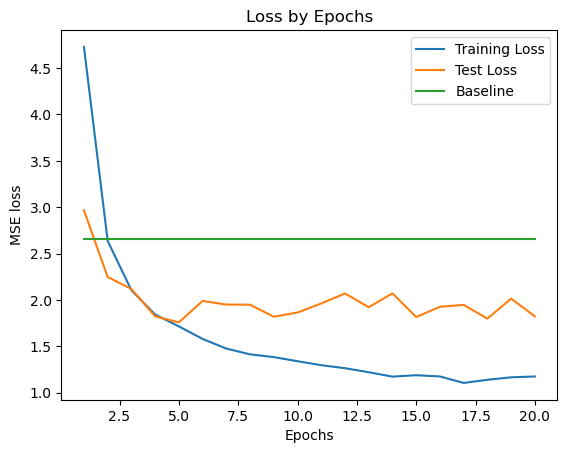

In [27]:
baseLossPlt = [baselineLoss] * numEpochs

print(baselineLoss)

yLst = list(range(1,21))

plt.plot(yLst, trainLossPlt)
plt.plot(yLst, testLossPlt)
plt.plot(yLst, baseLossPlt)

plt.title("Loss by Epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.legend(["Training Loss", "Test Loss", "Baseline"])

plt.show()